----
# Auto-ARIMA Forecasting
-----

In this notebook, I explore timeseries forecasting of stock returns using : ARIMA, SARIMA, and SARIMAX. For this analysis, I will be using the pmdarima package. This library simplifies the implementation and tuning of ARIMA and its paramters - this is particularly helpful when forecasting stock related data due to the high volatility. 

### Notebook Overview

The purpose of this project is to predict the 7-day return of stock prices. To do this, I will:

1. **Data Loading and Preparation:** Load stock data and calculate stock return

2. **Forecasting with Auto ARIMA:** Use pmdarima to automatically identify the best paramters for ARIMA forecasting.

3. **Incorporate Seasonality with SARIMA:** Extend the ARIMA model to capture seasonal effects using pmdarima.

4. **Further Enhance Forecasting with SARIMAX:** Use exogenous variables such as interest rates to improve forecasting accuracy.

5. **Evaluate Model Performance:** Assess the accuracy of our forecasts and analySe residuals to ensure the model’s effectiveness.


## Set Up
----

In [424]:
import numpy as np
import pandas as pd

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Utility Functions
----

In [425]:
def adf_test(series, threshold = 0.05):
    """
    Description:
    Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity.

    Parameters:
    - series : The time series data to test for stationarity.
    - threshold : The significance level to determine stationarity (default is 0.05).

    Returns:
    - None: Prints the ADF statistic, p-value and stationarity result.
    """
    adf_test = adfuller(series)
    adf_statistic = adf_test[0]
    p_value = adf_test[1]
    
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')

    if p_value < threshold:
        print("Data is stationary.")
    else:
        print("Data is not stationary.")

In [426]:
def plt_pred_vs_actual(actual, predicted):
    
    """
    Description:
    Plots the actual versus forecasted returns.

    Parameters:
    - actual: DataFrame containing actual returns with a DateTime index and a 'return' column.
    - predicted: Series containing forecasted returns, with the same index as 'actual'.

    Returns:
    - Displays the plot.
    """

     # Validate inputs
    if not isinstance(actual, pd.DataFrame):
        raise TypeError("Expected 'actual' to be a pandas DataFrame.")
    if not isinstance(predicted, pd.Series):
        raise TypeError("Expected 'predicted' to be a pandas Series with same index (Date) as actual")

    plt.figure(figsize=(10, 5))

    plt.plot(actual.index, actual['Close'], label='Actual Returns')
    plt.plot(actual.index, predicted, label='Forecasted Returns', color='red')
    ax = plt.gca()

    ax.spines[['top', 'right']].set_visible(False)
    plt.title('Returns Forecast vs Actual', fontweight = 'bold', fontsize = '15')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

In [427]:
def inv_diff(last_observed_value, predicted):
    """
    Description:
    Reverts a differenced time series to its original scale

    Parameters:
    - last_observed_value : The last observed value from the original time series.
    - predicted : Series containing the differenced forecasted values to be restored.

    Returns:
    - restored_series : Series with the restored predicted values 

    """    
    current_value = last_observed_value

    inv_diff_values = []

    for diff in predicted:
        inv_diff_value = current_value + diff
        inv_diff_values.append(inv_diff_value)
        current_value = inv_diff_value  

    restored_series = pd.Series(inv_diff_values, index=predicted.index)

    return restored_series

In [428]:
def fcast_evaluation(predicted, actual):
    """
    Description:
    To evaluate forecasting performance using multiple metrics.

    Parameters:
    predicted: Forecasted values.
    actual: Actual observed values.

    Output:
    A dictionary containing the evaluation metrics:
        - 'MSE': Mean Squared Error
        - 'MAE': Mean Absolute Error
        - 'RMSE': Root Mean Squared Error
        - 'MAPE': Mean Absolute Percentage Error
    """

    err= actual - predicted

    # Calculating MSE
    mse = mean_squared_error(actual, predicted)

    # Calculating MAE
    mae = mean_absolute_error(actual, predicted)

    # Calculating RMSE
    rmse = np.sqrt(mse)

    # Calculating MAPE
    abs_percent_err = np.abs(err/actual)
    mape = abs_percent_err.mean() * 100

    return {'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
            }

## Data Loading
----

In [429]:
raw_df = pd.read_csv('../../data/daily_data_clean.csv', index_col = 0)

In [430]:
# Turn index to DateTime 
raw_df.index = pd.DatetimeIndex(raw_df.index)

## Data Processing - Close
----

In [431]:
adf_test(raw_df['Close'])

ADF Statistic: -0.5313747600856212
p-value: 0.885747146071565
Data is not stationary.


In [432]:
# Apply boxcox first to stabalise the variance
raw_df['Close_boxcox'], lam = boxcox(raw_df['Close'])

In [433]:
# Already know seasonality of Close is 7 days
raw_df['Close_diff'] = raw_df['Close_boxcox'].diff(7)

In [434]:
raw_df = raw_df.dropna()

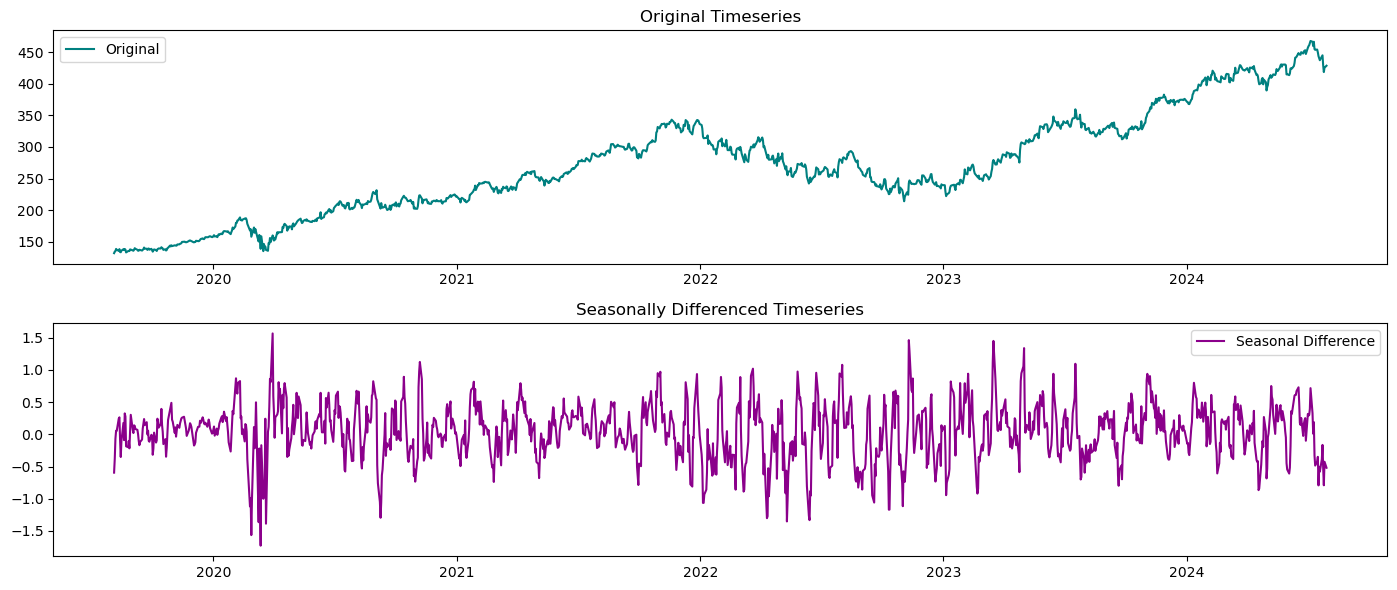

In [435]:
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(raw_df['Close'], label='Original', color= 'teal')
plt.title('Original Timeseries')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(raw_df['Close_diff'], label='Seasonal Difference', color='darkmagenta')
plt.title('Seasonally Differenced Timeseries')
plt.legend()

plt.tight_layout()
plt.show()

In [436]:
adf_test(raw_df['Close_diff'])

ADF Statistic: -8.147817688059595
p-value: 9.879557431344554e-13
Data is stationary.


-----
**Comment:**

Close data is now stationary after applying boxcox and seasonal differencing of 7 days.


## Train/Test Split
----

Since the purpose of this project is to forecast the daily return for the next 7 days, I will use a 1 week validation set.

In [437]:
train_end_date = raw_df.index.max() - pd.DateOffset(weeks=1)

In [492]:
from sklearn.model_selection import TimeSeriesSplit

In [494]:
tscv = TimeSeriesSplit(n_splits=5)

In [501]:
for train_index, test_index in tscv.split(raw_df):
    train_data, test_data = raw_df.iloc[train_index,:], raw_df.iloc[test_index,:]

In [438]:
# train_df = raw_df[raw_df.index <= train_end_date]
# val_df = raw_df[raw_df.index > train_end_date]

In [503]:
test_data

,Open,High,Low,Close,Adj Close,Volume,Close_boxcox,Close_diff
2023-10-01,316.769999,321.083344,315.113332,319.783325,317.972992,2.176010e+07,27.755950,0.102670
2023-10-02,316.279999,321.890015,315.179993,321.799988,319.978241,2.057000e+07,27.841184,0.180394
2023-10-03,320.829987,321.390015,311.209991,313.390015,311.615845,2.103350e+07,27.483772,0.053570
2023-10-04,314.029999,320.040009,314.000000,318.959991,317.154327,2.072010e+07,27.721067,0.262994
2023-10-05,319.089996,319.980011,314.899994,319.359985,317.552063,1.696560e+07,27.738020,0.243548
...,...,...,...,...,...,...,...,...
2024-07-25,428.799988,429.799988,417.510010,418.399994,418.399994,2.994380e+07,31.625308,-0.791459
2024-07-26,418.200012,428.920013,417.269989,425.269989,425.269989,2.356650e+07,31.875194,-0.425522
2024-07-27,422.650004,429.996673,419.748057,426.313324,426.313324,1.841836e+07,31.912950,-0.457003
2024-07-28,427.099996,431.073334,422.226125,427.356659,427.356659,1.327022e+07,31.950655,-0.488366


## Auto-Arima Forecasting
-----

### Define parameters for auto_arima function

In [504]:
y = train_data['Close_diff']

In [505]:
from pmdarima import auto_arima

# Fit auto_arima model on the daily return (y)
arima_model = auto_arima(y, seasonal=False, stepwise=True)

# Display the model summary
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1518
Model:               SARIMAX(2, 0, 3)   Log Likelihood                 125.268
Date:                Thu, 12 Sep 2024   AIC                           -236.537
Time:                        11:09:46   BIC                           -199.261
Sample:                    08-05-2019   HQIC                          -222.658
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0111      0.006      1.877      0.061      -0.000       0.023
ar.L1          1.4072      0.022     65.286      0.000       1.365       1.449
ar.L2         -0.6686      0.020    -32.961      0.0

-----
**Commment:** 

- Order of the ARIMA model: 
    - p = 2 Two autoregressive terms
    - d = 0 No differencing (data is stationary)
    - q = 3 Three moving average terms 

- **Auto-Regressive Terms:**

    - **ar.L1: 1.4036**

    Suggests a significant positive influence from returns exactly one day ago. This means that if the return a day ago was high, the model expects the current return to also be higher.

    - **ar.L2: -0.6615**

    The negative coefficient suggests the value two days ago was high and so can expect the current value to be lower.

- **Moving Average Terms** : showing influence of the error from the previous period on the current value

    - **ma.L1: -0.7290**

    The negative coefficient suggests the forecast for the previous day was too high, and so the model adjusts the forecast downwards. This adjustment helps to correct the model's overestimations. 

    - **ma.L2: 0.2878**

    A positive coefficient implies that if the error two days ago was high, the model adjusts the forecast upwards.

    - **ma.L3: 0.4803**




In [506]:
fcast_range = test_data.shape[0]

In [507]:
# Using .predict to forecast return for the next 7 days
pred_y = arima_model.predict(n_periods=fcast_range)

In [508]:
pred_y = inv_boxcox(pred_y, lam)

In [514]:
inversed_close = inv_diff(train_data['Close'].iloc[-1] , pred_y)

In [554]:
test_data.shape


(302, 11)

In [555]:
inversed_close.shape

(303,)

In [557]:
test_data


,Open,High,Low,Close,Adj Close,Volume,Close_boxcox,Close_diff,interest_rate,5D_M_Avg,int_r_diff
2023-10-02,316.279999,321.890015,315.179993,321.799988,319.978241,2.057000e+07,27.841184,0.180394,5.315,0.000661,0.005
2023-10-03,320.829987,321.390015,311.209991,313.390015,311.615845,2.103350e+07,27.483772,0.053570,5.340,0.061526,0.025
2023-10-04,314.029999,320.040009,314.000000,318.959991,317.154327,2.072010e+07,27.721067,0.262994,5.335,0.124856,-0.005
2023-10-05,319.089996,319.980011,314.899994,319.359985,317.552063,1.696560e+07,27.738020,0.243548,5.325,0.168635,-0.010
2023-10-06,316.549988,329.190002,316.299988,327.260010,325.407349,2.564550e+07,28.070492,0.485898,5.348,0.245281,0.023
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-25,428.799988,429.799988,417.510010,418.399994,418.399994,2.994380e+07,31.625308,-0.791459,5.160,-0.463491,-0.010
2024-07-26,418.200012,428.920013,417.269989,425.269989,425.269989,2.356650e+07,31.875194,-0.425522,5.155,-0.458246,-0.005
2024-07-27,422.650004,429.996673,419.748057,426.313324,426.313324,1.841836e+07,31.912950,-0.457003,5.155,-0.472123,0.000
2024-07-28,427.099996,431.073334,422.226125,427.356659,427.356659,1.327022e+07,31.950655,-0.488366,5.155,-0.536893,0.000


In [560]:
inversed_close.iloc[1:]

2023-10-02    320.107027
2023-10-03    321.440308
2023-10-04    322.749511
2023-10-05    323.970502
2023-10-06    325.087680
                 ...    
2024-07-25    630.507249
2024-07-26    631.550403
2024-07-27    632.593556
2024-07-28    633.636710
2024-07-29    634.679864
Freq: D, Length: 302, dtype: float64

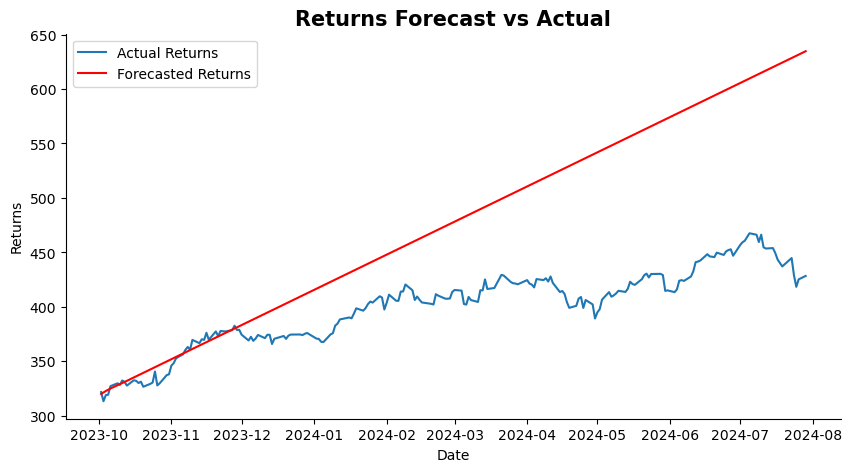

In [561]:
plt_pred_vs_actual(test_data, inversed_close.iloc[1:])

-----
**Plot Description:**

The model fails to respond to the sharp decline seen in the first couple of days in the validation dataset. This is clear as the forecasted line shows a steady upward trend throughout the seven days. 

This could be due to the AR coefficients - the strong positive influence from the previous day could have smoothed the volatility ?

## Auto-Sarima Forecasting
------

In [516]:
y = train_data['Close_diff']

In [517]:
# Setting seasonal to True and adding seasonal period 7 days
sarima_model = auto_arima(y, seasonal=True, m=7, stepwise=True)
print(sarima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1518
Model:             SARIMAX(2, 0, 2)x(0, 0, [1], 7)   Log Likelihood                 381.644
Date:                             Thu, 12 Sep 2024   AIC                           -749.288
Time:                                     11:12:17   BIC                           -712.012
Sample:                                 08-05-2019   HQIC                          -735.410
                                      - 09-30-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.000      3.570      0.000       0.000       0.001
ar.L1          1.8479      

------
**Comment:**

#TODO


In [518]:
fcast_range = test_data.shape[0]

In [519]:
s_pred_y = sarima_model.predict(n_periods= fcast_range)

In [520]:
s_pred_y 


2023-10-01    0.071832
2023-10-02    0.130814
2023-10-03    0.390782
2023-10-04    0.362638
2023-10-05    0.359677
                ...   
2024-07-25    0.040973
2024-07-26    0.040973
2024-07-27    0.040973
2024-07-28    0.040973
2024-07-29    0.040973
Freq: D, Length: 303, dtype: float64

    2024-07-23   -0.188649
    2024-07-24    0.013511
    2024-07-25    0.147730
    2024-07-26    0.198420
    2024-07-27    0.180788
    2024-07-28    0.122509
    2024-07-29    0.052371
    Freq: D, dtype: float64

In [521]:
s_pred_y = inv_boxcox(s_pred_y, lam)

In [522]:
inversed_close_s = inv_diff(train_data['Close'].iloc[-1],s_pred_y)

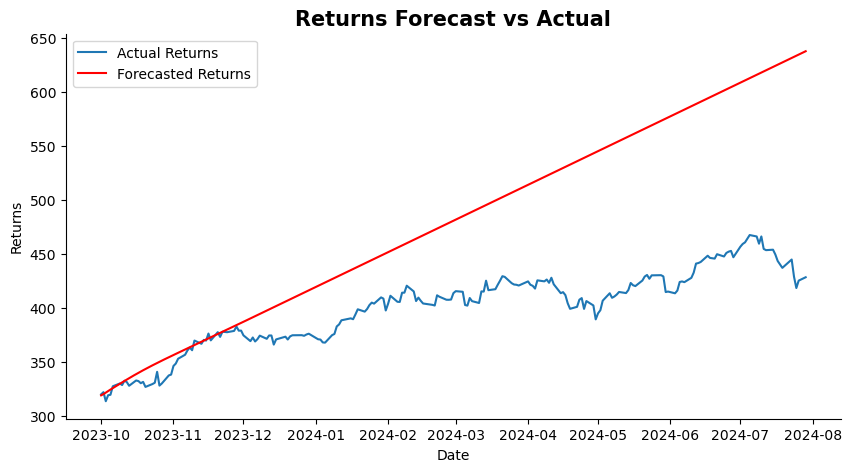

In [523]:
plt_pred_vs_actual(test_data, inversed_close_s)


-----
**Plot Description:**
#TODO



## Auto-Sarimax Forecasting
----

### Adding interest rates

**NOTE:** 

Interest rates affect stock prices in several ways. 

When interest rates are low, it’s cheaper for companies to borrow money, which can lead to more investment and higher profits, often boosting stock prices.

Higher interest rates make bonds and savings accounts more attractive, leading investors to move money away from stocks, which can lower stock prices.

By including interest rates as an exogenous variable, the model can account for these effects use them to improve the accuracy of its predictions.

In [524]:
# Using yfinance to get interest rates
import yfinance as yf

treasury_data = yf.download('^IRX', start=raw_df.index.min(), end=raw_df.index.max())

[*********************100%%**********************]  1 of 1 completed


In [525]:
raw_df.index.max()

Timestamp('2024-07-29 00:00:00')

### Checking for missing dates

In [526]:
first_day = raw_df.index.min()
last_day = raw_df.index.max()

In [527]:
# Calculate difference between last and first day
last_day -  first_day

Timedelta('1820 days 00:00:00')

In [528]:
# Clearly missing dates
treasury_data.shape

(1253, 6)

In [529]:
# Calculate full date range from start to end date
full_index = pd.date_range(start=first_day, end=last_day, freq='D')

In [530]:
# Re-index so there are no more missing dates
treasury_data = treasury_data.reindex(full_index)

In [531]:
full_index.difference(treasury_data.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [532]:
treasury_data.isna().sum()

Open         568
High         568
Low          568
Close        568
Adj Close    568
Volume       568
dtype: int64

In [533]:
# Fill in missing data for added dates using interpolation
treasury_data= treasury_data.interpolate(method='linear')

In [535]:
treasury_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [465]:
treasury_data = treasury_data.rename(columns={"Adj Close": "interest_rate"}) # TODO: CHECK

### Merging with raw_df

In [466]:
# Create new df irt_df to hold raw_df data + interest rate data
# Merging raw_df with interest rate on date index
irt_df = pd.merge(raw_df, treasury_data['interest_rate'], left_index=True, right_index=True)

In [537]:
# Checking for null values 
irt_df.isna().sum()

Open             0
High             0
Low              0
Close            0
Adj Close        0
Volume           0
Close_boxcox     0
Close_diff       0
interest_rate    0
5D_M_Avg         0
int_r_diff       0
dtype: int64

In [538]:
irt_df.index

DatetimeIndex(['2019-08-09', '2019-08-10', '2019-08-11', '2019-08-12',
               '2019-08-13', '2019-08-14', '2019-08-15', '2019-08-16',
               '2019-08-17', '2019-08-18',
               ...
               '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23',
               '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-27',
               '2024-07-28', '2024-07-29'],
              dtype='datetime64[ns]', length=1817, freq=None)

### Adding 5 day moving average

In [469]:
irt_df['5D_M_Avg'] = irt_df['Close_diff'].rolling(window=5).mean()

In [539]:
irt_df

,Open,High,Low,Close,Adj Close,Volume,Close_boxcox,Close_diff,interest_rate,5D_M_Avg,int_r_diff
2019-08-09,138.610001,139.380005,136.460007,137.710007,131.333435,2.346670e+07,18.269096,0.054515,1.950000,-0.186573,-0.020000
2019-08-10,138.096670,138.873337,136.053340,137.070002,130.723083,2.247257e+07,18.226037,0.117174,1.942667,-0.044075,-0.007333
2019-08-11,137.583338,138.366669,135.646672,136.429998,130.112732,2.147843e+07,18.182868,0.180393,1.935333,0.068129,-0.007333
2019-08-12,137.070007,137.860001,135.240005,135.789993,129.502380,2.048430e+07,18.139588,0.244186,1.928000,0.130374,-0.007333
2019-08-13,136.050003,138.800003,135.000000,138.600006,132.182236,2.515460e+07,18.328792,0.263854,1.955000,0.172024,0.027000
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-25,428.799988,429.799988,417.510010,418.399994,418.399994,2.994380e+07,31.625308,-0.791459,5.160000,-0.463491,-0.010000
2024-07-26,418.200012,428.920013,417.269989,425.269989,425.269989,2.356650e+07,31.875194,-0.425522,5.155000,-0.458246,-0.005000
2024-07-27,422.650004,429.996673,419.748057,426.313324,426.313324,1.841836e+07,31.912950,-0.457003,5.155000,-0.472123,0.000000
2024-07-28,427.099996,431.073334,422.226125,427.356659,427.356659,1.327022e+07,31.950655,-0.488366,5.155000,-0.536893,0.000000


### Checking stationarity of X vars

#### Interest Rate

In [471]:
# Check if interest data is stationary 
adf_test(irt_df['interest_rate'])

ADF Statistic: 0.15089495581818316
p-value: 0.969368987066434
Data is not stationary.


In [472]:
# Apply boxcox to stabalise variance - negative values when using irx
#irt_df['itr_stat'], _ = boxcox(irt_df['interest_rate'])

In [473]:
#adf_test(irt_df['itr_stat'])

In [474]:
# Applying differencing to stabalise the mean 
irt_df['int_r_diff']= irt_df['interest_rate'].diff().dropna()

In [475]:
irt_df = irt_df.dropna()

In [476]:
adf_test(irt_df['int_r_diff'])

ADF Statistic: -6.769031696647269
p-value: 2.671025372424806e-09
Data is stationary.


#### 5-Day Moving Average

In [477]:
adf_test(irt_df['5D_M_Avg'])

ADF Statistic: -7.12129035417328
p-value: 3.7167156436636384e-10
Data is stationary.


#### Volume

In [478]:
adf_test(irt_df['Volume'])

ADF Statistic: -5.25319976944865
p-value: 6.8399794038629755e-06
Data is stationary.


### Train/Test Split (new df)


In [479]:
train_df = irt_df.iloc[:-7]
val_df = irt_df.iloc[-7:]  

In [541]:
for train_index, test_index in tscv.split(irt_df):
    train_df, val_df = irt_df.iloc[train_index,:], irt_df.iloc[test_index,:]

### Selecting X and y

In [542]:
y = train_df['Close_diff']
# Exogenous variables 
X = train_df[['int_r_diff', 'Volume','5D_M_Avg']]

### Running SARIMAX Forecasting

In [543]:
X

,int_r_diff,Volume,5D_M_Avg
2019-08-09,-0.020000,2.346670e+07,-0.186573
2019-08-10,-0.007333,2.247257e+07,-0.044075
2019-08-11,-0.007333,2.147843e+07,0.068129
2019-08-12,-0.007333,2.048430e+07,0.130374
2019-08-13,0.027000,2.515460e+07,0.172024
...,...,...,...
2023-09-27,0.005000,1.941010e+07,-0.512662
2023-09-28,-0.022000,1.968360e+07,-0.456398
2023-09-29,-0.008000,2.414030e+07,-0.365438
2023-09-30,0.005000,2.295020e+07,-0.263540


In [544]:
# Fit auto_arima model on the stationary returns
sarimax_model = auto_arima(y, exogenous = X,seasonal=True, m=7, stepwise=True)

# Display the model summary
print(sarimax_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1515
Model:             SARIMAX(2, 0, 2)x(0, 0, [1], 7)   Log Likelihood                 389.097
Date:                             Thu, 12 Sep 2024   AIC                           -764.194
Time:                                     11:16:19   BIC                           -726.931
Sample:                                 08-09-2019   HQIC                          -750.319
                                      - 10-01-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.000      3.916      0.000       0.000       0.001
ar.L1          1.8488      

------
**Plot Description:**

#TODO

In [545]:
# Forecast future returns on the test set period
forecast_periods = val_df.shape[0]

In [546]:
future_exog = val_df[['int_r_diff', 'Volume', '5D_M_Avg']]

In [547]:
x_pred_y = sarimax_model.predict( exog=future_exog, n_periods=forecast_periods)

In [548]:
x_pred_y = inv_boxcox(x_pred_y, lam)

In [549]:
inversed_close_s_x = inv_diff(train_df['Close'].iloc[-1] , x_pred_y)

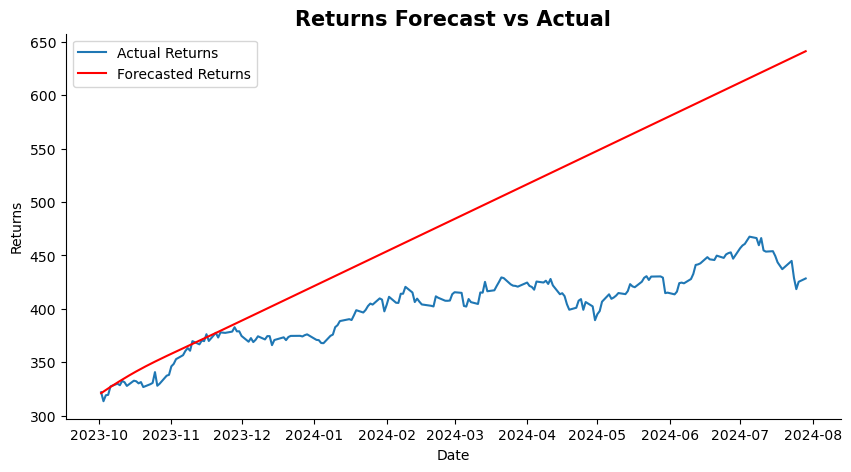

In [550]:
plt_pred_vs_actual(val_df, inversed_close_s_x)

----
**Plot Description:**

#TODO

## Evaluation
----

In [562]:
fcast_evaluation(inversed_close.iloc[1:], test_data['Close'])

{'MSE': 9612.296131395356,
 'MAE': 78.03311754124685,
 'RMSE': 98.04231806416736,
 'MAPE': 18.558052232845252}

In [564]:
fcast_evaluation(inversed_close_s.iloc[1:], test_data['Close'])

{'MSE': 10176.968166629336,
 'MAE': 81.19770258481364,
 'RMSE': 100.88096037721556,
 'MAPE': 19.344091406457828}

In [567]:
fcast_evaluation(inversed_close_s_x, val_df['Close'])

{'MSE': 10616.386623074053,
 'MAE': 83.4069594698788,
 'RMSE': 103.03585115421745,
 'MAPE': 19.88684977948543}

----
#TODO:

- comments and plot descriptions 
- conclusion